# AKLT Forced Measurement Protocol

This notebook demonstrates forced measurement on spin-1 (S=1) chains using:

- **Protocol A**: `SpinSectorProjection` (coherent projection, preserves superposition)

## Physics Background

Coherent projection removes unwanted spin sectors (S=2) while preserving quantum superposition of allowed sectors (S=0 and S=1). This enables deterministic convergence to the AKLT ground state.

## Background: AKLT State

The **AKLT state** (Affleck-Kennedy-Lieb-Tasaki) is the unique ground state of a spin-1 chain with the Hamiltonian:

$$H = \sum_i \left[ \vec{S}_i \cdot \vec{S}_{i+1} + \frac{1}{3} (\vec{S}_i \cdot \vec{S}_{i+1})^2 \right]$$

where $\vec{S}_i$ are spin-1 operators.

### Total Spin Sectors

Two spin-1 particles can combine into three total spin sectors:
- **S = 0** (singlet, 1 state)
- **S = 1** (triplet, 3 states)
- **S = 2** (quintet, 5 states)

The AKLT state lives in the S ∈ {0, 1} subspace—it contains no S=2 quintets.

### String Order Parameter

The string order parameter is a non-local observable that characterizes the AKLT ground state:

$$O_{\text{string}}(i, j) = \langle S^z_i \exp\left(i\pi \sum_{k=i+1}^{j-1} S^z_k\right) S^z_j \rangle$$

For the AKLT ground state on a periodic chain:

$$|O_{\text{string}}| \to \frac{4}{9} \approx 0.444$$

This is our validation metric: if the protocol converges to AKLT, we should see |SO| ≈ 4/9.

## Setup

Activate the project and load required packages:

In [1]:
using Pkg; Pkg.activate(dirname(@__DIR__))
using QuantumCircuitsMPS
using LinearAlgebra
using ITensorMPS
using Printf
using Plots
using Statistics

  Activating project at `/mnt/d/Rutgers/QuantumCircuitsMPS.jl`


## Parameters

Define the system parameters for both protocols:

In [2]:
L = 8             # Chain length (divisible by 4 for NNN coverage)
n_layers = L       # Number of projection layers
bc = :periodic     # Boundary conditions (less ambiguous than :open)
p_nn = 0.0         # Probability of NN projection
maxdim = 128       # Maximum bond dimension

# NOTE on boundary conditions:
# We use bc=:periodic which gives well-defined physics for AKLT:
# - NN AKLT: |SO| ≈ 4/9, S = 2 (in base 2)
# - NNN AKLT: |SO| ≈ (4/9)² ≈ 0.198, S = 4 (in base 2)

println("System Parameters:")
println("  L = $L (chain length)")
println("  n_layers = $n_layers")
println("  bc = $bc")
println("  p_nn = $p_nn (probability of NN projection)")
println("  p_nnn = $(1-p_nn) (probability of NNN projection)")
println("  maxdim = $maxdim")
println()

System Parameters:
  L = 8 (chain length)
  n_layers = 8
  bc = periodic
  p_nn = 0.0 (probability of NN projection)
  p_nnn = 1.0 (probability of NNN projection)
  maxdim = 128




## Physics Sanity Check

Expected values for bc=:periodic with base 2 logarithm:

| p_nn | p_nnn | Ground State | |SO|           | S (von Neumann) |
|------|-------|--------------|----------------|-----------------||
|  1   |   0   | NN AKLT      | 4/9 ≈ 0.444    |        2        |
|  0   |   1   | NNN AKLT     | (4/9)² ≈ 0.198 |        4        |

## Gate Construction

Create the projector gate for Protocol A:

In [3]:
# Spin projectors: P₀ (singlet), P₁ (triplet), P₂ (quintet)
P0 = total_spin_projector(0)
P1 = total_spin_projector(1)
P_not_2 = P0 + P1  # Projects out S=2 sector

# Protocol A gate: Coherent projection (preserves S=0/S=1 superposition)
proj_gate = SpinSectorProjection(P_not_2)

println("Gate constructed:")
println("  SpinSectorProjection(P₀+P₁) - coherent projection")
println()

Gate constructed:
  SpinSectorProjection(P₀+P₁) - coherent projection



## Protocol A: Coherent Projection with NN+NNN (SpinSectorProjection)

**How it works:**

Protocol A uses the `SpinSectorProjection` gate, which applies a projector operator to pairs of sites:

$$|\psi\rangle \to \frac{(P_0 + P_1)|\psi\rangle}{\|(P_0 + P_1)|\psi\rangle\|}$$

where $P_S$ projects onto total spin sector $S$. This:

1. **Removes S=2 quintets** from the two-qubit Hilbert space
2. **Preserves coherent superposition** of S=0 and S=1 sectors
3. **Does not collapse** the wavefunction stochastically

**NN+NNN Probabilistic Selection:**

We use `apply_with_prob!` to probabilistically choose between:
- **Nearest-Neighbor (NN)** projections with probability `p_nn = 0.7`: pairs (1,2), (3,4), ...
- **Next-Nearest-Neighbor (NNN)** projections with probability `1-p_nn = 0.3`: pairs (1,3), (5,7), ...

After L layers of mixed NN+NNN projections, this protocol still converges to the AKLT ground state, though possibly at a slower rate than pure NN (p_nn=1.0).

In [16]:
p_nn = .6
L=8
n_layers = L 

8

In [4]:
println("═"^70)
println("Protocol A: SpinSectorProjection (Coherent) with NN+NNN")
println("═"^70)

# Define circuit using declarative API
# n_steps=1 means this circuit represents ONE layer
# simulate!(circuit, state; n_circuits=n_layers) runs it n_layers times
#
# IMPORTANT: For complete NNN coverage, we need all 4 sublayers:
# - :nnn_odd_1, :nnn_odd_2 (pairs (1,3), (5,7) and (3,5), (7,1))
# - :nnn_even_1, :nnn_even_2 (pairs (2,4), (6,8) and (4,6), (8,2))
# This covers all NNN pairs on a periodic chain.
circuit_A = Circuit(L=L, bc=bc, n_steps=1, p_nn=p_nn, proj_gate=proj_gate) do c
    # Single stochastic call: NN vs NNN with automatic pair coverage
    # :nn parity auto-expands to all NN pairs (combines :odd + :even)
    # :nnn parity auto-expands to all NNN pairs (combines 4 sublayers)
    # Parameters accessed via c.params[:key] for self-contained circuits
    apply_with_prob!(c; rng=:ctrl, outcomes=[
        (probability=c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nn)),
        (probability=1-c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nnn))
    ])
end

println("✓ Circuit defined with apply_with_prob! (p_nn=$p_nn)")
if p_nn == 1.0
    println("  - Pure NN: Bricklayer(:nn) auto-expands to all 12 NN pairs")
elseif p_nn == 0.0
    println("  - Pure NNN: Bricklayer(:nnn) auto-expands to all 12 NNN pairs")
else
    println("  - Mixed NN/NNN: p=$p_nn uses :nn, p=$(1-p_nn) uses :nnn")
end

# Initialize state with RNG for probabilistic decisions
rng_reg_A = RNGRegistry(ctrl=42, proj=1, haar=2, born=3)
state_A = SimulationState(L=L, bc=bc, site_type="S=1", maxdim=maxdim, rng=rng_reg_A)
state_A.mps = MPS(state_A.sites, ["Z0" for _ in 1:L])
println("✓ Initialized to |Z0⟩⊗$L (m=0 product state)")

# Track observables
track!(state_A, :entropy => EntanglementEntropy(cut=L÷2, renyi_index=1, base=2))
# Use order=2 for NNN regime (paired endpoints), order=1 for NN
so_order = p_nn == 1.0 ? 1 : (p_nn == 0.0 ? 2 : 1)
track!(state_A, :string_order => StringOrder(1, L÷2+1, order=so_order))
println("✓ Tracking: entropy, string_order")

# Run simulation: n_layers iterations of the circuit
println("\nRunning $n_layers layers of NN+NNN projections (p_nn=$p_nn)...")
simulate!(circuit_A, state_A; n_circuits=n_layers, record_when=:every_step)

# Report results
for layer in [1, n_layers÷2, n_layers]
    S = state_A.observables[:entropy][layer]
    SO = state_A.observables[:string_order][layer]
    println("  Layer $layer: S=$(round(S, digits=4)), |SO|=$(round(abs(SO), digits=4))")
end

S_final_A = state_A.observables[:entropy][end]
SO_final_A = state_A.observables[:string_order][end]

println("\nProtocol A Results:")
println("  Final entropy: $(round(S_final_A, digits=4))")
println("  Final |string order|: $(round(abs(SO_final_A), digits=4))")

# Expected physics based on p_nn
expected_SO = p_nn == 1.0 ? 4/9 : (p_nn == 0.0 ? (4/9)^2 : NaN)
expected_S = p_nn == 1.0 ? 2.0 : (p_nn == 0.0 ? 4.0 : NaN)

println("  Expected for p_nn=$p_nn: |SO| ≈ $(isnan(expected_SO) ? "mixed" : round(expected_SO, digits=3)), S ≈ $(isnan(expected_S) ? "mixed" : round(expected_S, digits=1))")

if !isnan(expected_SO) && !isnan(expected_S)
    if abs(abs(SO_final_A) - expected_SO) < 0.1 && abs(S_final_A - expected_S) < 1.0
        println("  ✅ CONVERGED to $(p_nn == 1.0 ? "NN" : "NNN") AKLT ground state!")
    else
        println("  ⚠️  Did not fully converge (try increasing n_layers)")
    end
else
    println("  ℹ️  Mixed NN/NNN regime - no simple analytical expectation")
end
println()

══════════════════════════════════════════════════════════════════════
Protocol A: SpinSectorProjection (Coherent) with NN+NNN
══════════════════════════════════════════════════════════════════════
✓ Circuit defined with apply_with_prob! (p_nn=0.0)
  - Pure NNN: Bricklayer(:nnn) auto-expands to all 12 NNN pairs
✓ Initialized to |Z0⟩⊗8 (m=0 product state)
✓ Tracking: entropy, string_order

Running 8 layers of NN+NNN projections (p_nn=0.0)...
  Layer 1: S=4.0, |SO|=0.2101
  Layer 4: S=3.7818, |SO|=0.2268
  Layer 8: S=3.7818, |SO|=0.2268

Protocol A Results:
  Final entropy: 3.7818
  Final |string order|: 0.2268
  Expected for p_nn=0.0: |SO| ≈ 0.198, S ≈ 4.0
  ✅ CONVERGED to NNN AKLT ground state!



In [5]:
circuit_A.n_steps

1

### Circuit Visualization

Visualize the circuit structure before running the simulation:

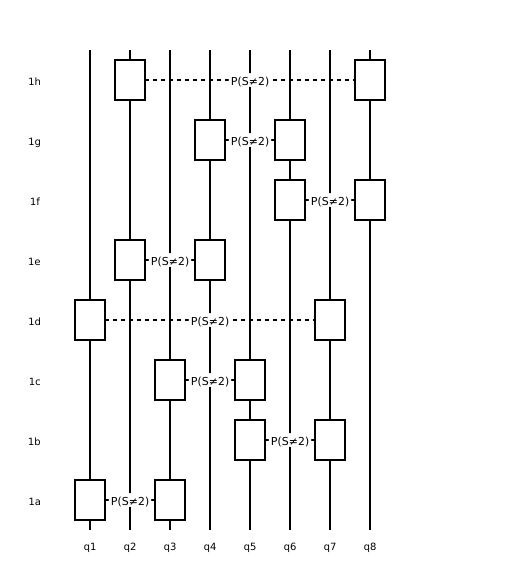

In [22]:
# ASCII visualization (no dependencies)
# print_circuit(circuit_A)

# SVG export (requires Luxor.jl)
using Luxor
plot_circuit(circuit_A; seed=3, )

## Parameter Sweep: Order Parameter and Entanglement Entropy

Compute the string order parameter and entanglement entropy for different system sizes (L) and NN probabilities (p_nn).

**Goal**: Map out how these observables depend on the NN/NNN mixing ratio across system sizes.

In [ ]:
# Parameter sweep: L × p × seed (parallel)
L_list = [8, 16]
p_list = 0:0.1:1.0 |> collect
seeds = 1:10

nL, np, ns = length(L_list), length(p_list), length(seeds)
configs = [(L=L, p=p, seed=s) for L in L_list for p in p_list for s in seeds]

function run_sim(cfg)
    L, p, seed = cfg.L, cfg.p, cfg.seed
    
    circuit = Circuit(L=L, bc=bc, n_steps=1, p_nn=p, proj_gate=proj_gate) do c
        apply_with_prob!(c; rng=:ctrl, outcomes=[
            (probability=c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nn)),
            (probability=1-c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nnn))
        ])
    end
    
    rng = RNGRegistry(ctrl=seed, proj=seed+100, haar=seed+200, born=seed+300)
    state = SimulationState(L=L, bc=bc, site_type="S=1", maxdim=maxdim, rng=rng)
    initialize!(state, ProductState(spin_state="Z0"))
    
    track!(state, :S => EntanglementEntropy(cut=L÷2, renyi_index=1, base=2))
    track!(state, :SO_nn => StringOrder(1, L÷2+1, order=1))
    track!(state, :SO_nnn => StringOrder(1, L÷2+1, order=2))
    
    simulate!(circuit, state; n_circuits=L, record_when=:final_only)
    
    (state.observables[:S][end], 
     abs(state.observables[:SO_nn][end]),
     abs(state.observables[:SO_nnn][end]))
end

println("Running $(length(configs)) configs on $(Threads.nthreads()) threads...")
@time raw = fetch.([Threads.@spawn run_sim(cfg) for cfg in configs])

# Reshape to 3D tensors: (L, p, seed)
S_raw = reshape([r[1] for r in raw], ns, np, nL)      # (seed, p, L)
SO_nn_raw = reshape([r[2] for r in raw], ns, np, nL)
SO_nnn_raw = reshape([r[3] for r in raw], ns, np, nL)

# Aggregate over seeds (dim 1)
S_mean = dropdims(mean(S_raw, dims=1), dims=1)         # (p, L)
S_std = dropdims(std(S_raw, dims=1), dims=1)
SO_nn_mean = dropdims(mean(SO_nn_raw, dims=1), dims=1)
SO_nn_std = dropdims(std(SO_nn_raw, dims=1), dims=1)
SO_nnn_mean = dropdims(mean(SO_nnn_raw, dims=1), dims=1)
SO_nnn_std = dropdims(std(SO_nnn_raw, dims=1), dims=1)

println("Done! Arrays: S_mean[$np×$nL], SO_nn_mean[$np×$nL], SO_nnn_mean[$np×$nL]")

Running 330 configs on 1 threads...
8851.533919 seconds (333.52 M allocations: 1.747 TiB, 5.07% gc time, 0.05% compilation time)
Done!
8851.533919 seconds (333.52 M allocations: 1.747 TiB, 5.07% gc time, 0.05% compilation time)
Done!


In [12]:
# Results table
for (iL, L) in enumerate(L_list)
    println("L=$L:")
    println("  p_nn    S          |SO_nn|     |SO_nnn|")
    for (ip, p) in enumerate(p_list)
        @printf("  %.1f   %.2f±%.2f   %.3f±%.3f   %.3f±%.3f\n", 
                p, S_mean[ip,iL], S_std[ip,iL], 
                SO_nn_mean[ip,iL], SO_nn_std[ip,iL], 
                SO_nnn_mean[ip,iL], SO_nnn_std[ip,iL])
    end
    println()
end

330-element Vector{@NamedTuple{L::Int64, p::Float64, seed::Int64, S::Float64, SO_nn::Float64, SO_nnn::Float64}}:
 (L = 8, p = 0.0, seed = 1, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 2, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 3, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 4, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 5, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 6, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 7, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8, p = 0.0, seed = 8, S = 3.781841987178396, SO_nn = 0.11337868498936667, SO_nnn = 0.22675736979823755)
 (L = 8

In [7]:
# Results table
for L in L_list
    println("L=$L:")
    println("  p_nn    S          |SO_nn|     |SO_nnn|")
    for p in p_list
        r = results[(L, p)]
        @printf("  %.1f   %.2f±%.2f   %.3f±%.3f   %.3f±%.3f\n", 
                p, r.S_mean, r.S_std, r.SO_nn_mean, r.SO_nn_std, r.SO_nnn_mean, r.SO_nnn_std)
    end
    println()
end

L=8:
  p_nn    S          |SO_nn|     |SO_nnn|
  0.0   3.78±0.00   0.113±0.000   0.227±0.000
  0.1   3.66±0.60   0.159±0.108   0.196±0.064
  0.2   3.47±0.79   0.193±0.138   0.180±0.075
  0.3   3.42±0.83   0.210±0.139   0.157±0.077
  0.4   3.12±0.83   0.221±0.161   0.135±0.085
  0.5   3.03±0.89   0.262±0.159   0.102±0.073
  0.6   2.67±0.76   0.275±0.177   0.079±0.065
  0.7   2.70±0.77   0.272±0.180   0.069±0.061
  0.8   2.36±0.54   0.293±0.197   0.069±0.062
  0.9   2.23±0.53   0.373±0.153   0.082±0.054
  1.0   2.00±0.00   0.445±0.000   0.073±0.000

L=12:
  p_nn    S          |SO_nn|     |SO_nnn|
  0.0   3.98±0.00   0.032±0.000   0.201±0.000
  0.1   3.98±0.00   0.032±0.001   0.201±0.000
  0.2   4.13±0.47   0.034±0.009   0.187±0.042
  0.3   4.23±0.56   0.035±0.010   0.166±0.056
  0.4   4.56±0.76   0.041±0.013   0.141±0.063
  0.5   3.80±1.32   0.161±0.187   0.084±0.069
  0.6   3.72±1.52   0.204±0.203   0.064±0.057
  0.7   2.99±1.57   0.318±0.199   0.042±0.049
  0.8   2.91±1.44   0.324±0.19

### Interpreting the Results

**Expected behavior:**
- **p_nn = 1.0** (pure NN): Converges to single AKLT chain. S ≈ 2.0, |SO| ≈ 4/9 ≈ 0.444
- **p_nn = 0.0** (pure NNN): Creates two decoupled AKLT chains. S ≈ 4.0, |SO| ≈ (4/9)² ≈ 0.198
- **0 < p_nn < 1** (mixed): Interpolates between these limits

**Note**: The crossover behavior between NN and NNN regimes depends on the competition between these two types of projections.

# Entanglement Entropy vs p_nn
colors = cgrad(:viridis, length(L_list), categorical=true)
p_ee = plot(xlabel="p_nn", ylabel="S", title="Entanglement Entropy", legend=:topright)

for (iL, L) in enumerate(L_list)
    plot!(p_ee, p_list, S_mean[:,iL], ribbon=S_std[:,iL], fillalpha=0.2, 
          label="L=$L", color=colors[iL], lw=2, marker=:o, ms=4)
end
hline!(p_ee, [2.0, 4.0], ls=:dash, color=:gray, alpha=0.5, label="")
display(p_ee)

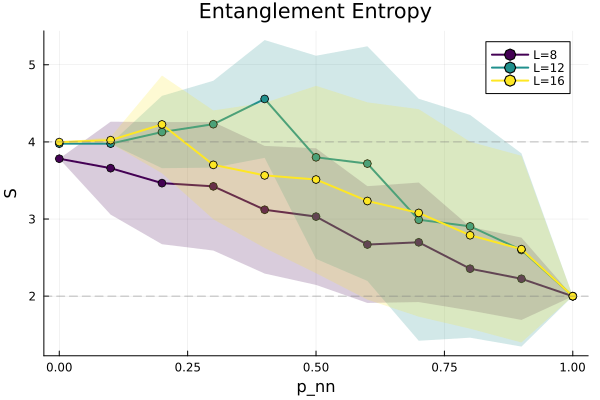

In [8]:
# NN String Order vs p_nn
colors = cgrad(:plasma, length(L_list), categorical=true)
p_so = plot(xlabel="p_nn", ylabel="|SO|", title="NN Order Parameter (order=1)", legend=:topright)

for (iL, L) in enumerate(L_list)
    plot!(p_so, p_list, SO_nn_mean[:,iL], ribbon=SO_nn_std[:,iL], fillalpha=0.2,
          label="L=$L", color=colors[iL], lw=2, marker=:s, ms=4)
end
hline!(p_so, [4/9], ls=:dash, color=:gray, alpha=0.5, label="4/9")
display(p_so)

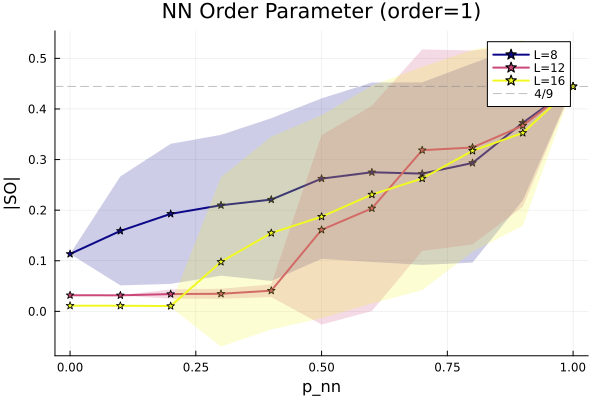

In [9]:
# NNN String Order vs p_nn
colors = cgrad(:inferno, length(L_list), categorical=true)
p_nnn = plot(xlabel="p_nn", ylabel="|SO|", title="NNN Order Parameter (order=2)", legend=:topright)

for (iL, L) in enumerate(L_list)
    plot!(p_nnn, p_list, SO_nnn_mean[:,iL], ribbon=SO_nnn_std[:,iL], fillalpha=0.2,
          label="L=$L", color=colors[iL], lw=2, marker=:d, ms=4)
end
hline!(p_nnn, [(4/9)^2], ls=:dash, color=:gray, alpha=0.5, label="(4/9)²")
display(p_nnn)

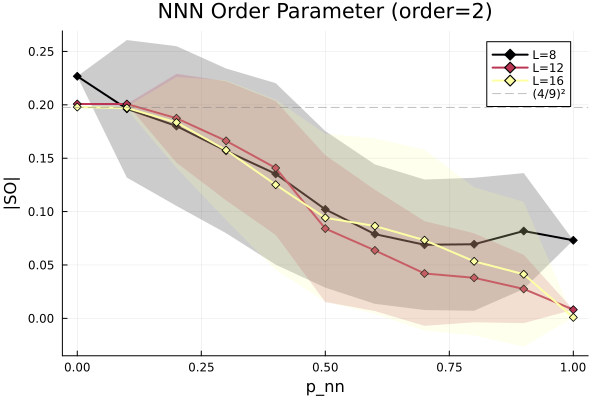

In [10]:
# NNN String Order vs p_nn
colors = cgrad(:inferno, length(L_list), categorical=true)
p_nnn = plot(xlabel="p_nn", ylabel="|SO|", title="NNN Order Parameter (order=2)", legend=:topright)

for (i, L) in enumerate(L_list)
    SO_vals = [results[(L, p)].SO_nnn_mean for p in p_list]
    SO_errs = [results[(L, p)].SO_nnn_std for p in p_list]
    plot!(p_nnn, p_list, SO_vals, ribbon=SO_errs, fillalpha=0.2,
          label="L=$L", color=colors[i], lw=2, marker=:d, ms=4)
end
hline!(p_nnn, [(4/9)^2], ls=:dash, color=:gray, alpha=0.5, label="(4/9)²")
display(p_nnn)

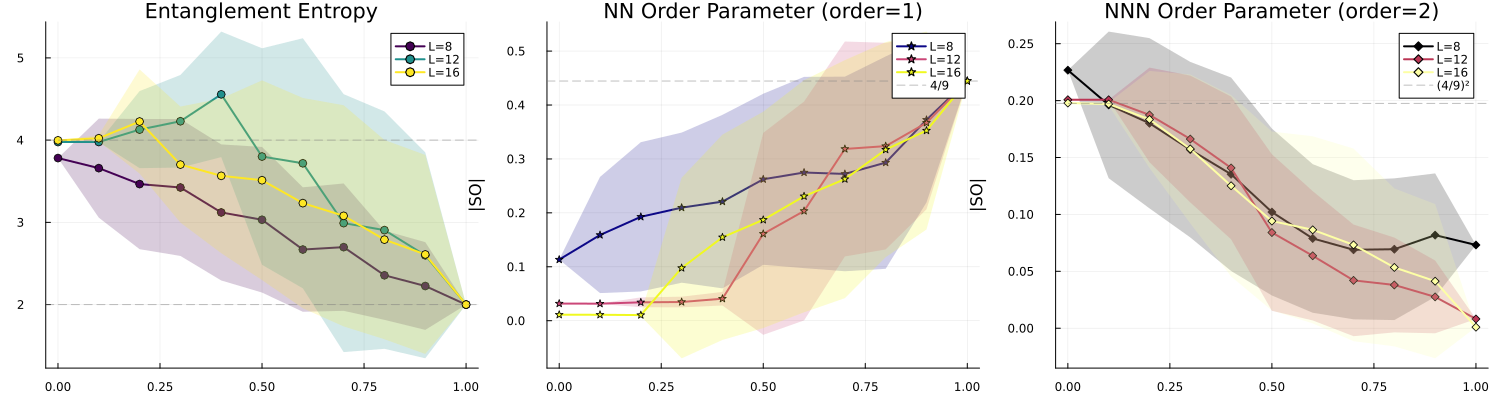

In [11]:
# Combined plot
plot(p_ee, p_so, p_nnn, layout=(1,3), size=(1500, 400))

In [ ]:
k